In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [2]:
#gdf_amg = aqiGDL.gdf_from_db('municipios_amg','areas')
gdf_amg = gpd.read_file('../data/external/amg_municipios.geojson')
gdf_amg = ox.project_gdf(gdf_amg,to_crs='EPSG:32613')
gdf_amg.head(2)

,CVE_ENT,CVE_MUN,NOM_MUN,OID,geometry
0,14,039,Guadalajara,631,"MULTIPOLYGON (((675777.419 2295506.182, 675934..."
1,14,044,Ixtlahuacán de los Membrillos,636,"MULTIPOLYGON (((686951.828 2265175.682, 687013..."


In [18]:
gdf_amg

,CVE_ENT,CVE_MUN,NOM_MUN,OID,geometry
0,14,039,Guadalajara,631,"MULTIPOLYGON (((675777.419 2295506.182, 675934..."
1,14,044,Ixtlahuacán de los Membrillos,636,"MULTIPOLYGON (((686951.828 2265175.682, 687013..."
2,14,051,Juanacatlán,643,"MULTIPOLYGON (((694191.088 2275866.762, 694897..."
3,14,070,El Salto,662,"MULTIPOLYGON (((675565.470 2276387.241, 675601..."
4,14,097,Tlajomulco de Zúñiga,689,"MULTIPOLYGON (((655964.795 2278802.763, 656001..."
5,14,098,San Pedro Tlaquepaque,690,"MULTIPOLYGON (((675553.549 2283904.987, 675671..."
6,14,101,Tonalá,693,"MULTIPOLYGON (((680912.260 2290409.175, 681093..."
7,14,120,Zapopan,712,"MULTIPOLYGON (((654446.664 2321638.111, 654518..."
8,14,124,Zapotlanejo,716,"MULTIPOLYGON (((702152.154 2300764.746, 702184..."


In [3]:
gdf_est = aqiGDL.gdf_from_db('puntos_pip','estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')
gdf_est.head(2)

,Nombre,Latitud,Longitud,geometry
0,Mercado Municipal de Zapopan,20.722076,-103.391246,POINT (667520.005 2292221.880)
1,Centro Cultural Constitución Zapopan,20.727291,-103.368109,POINT (669923.977 2292823.305)


In [4]:
gdf_edge = aqiGDL.gdf_from_db('guadalajara_edges','networks')
gdf_edge = ox.project_gdf(gdf_edge,to_crs='EPSG:32613')
gdf_edge.head(2)

,osmid,oneway,lanes,name,highway,maxspeed,length,ref,bridge,geometry,access,junction,tunnel,service,width,area,u,v,key
0,511127584,False,2,Calle San Nicolás Ocotillo,unclassified,None,23.309,None,None,"LINESTRING (685332.521 2280192.285, 685337.073...",None,None,None,None,None,None,6597423940,3786303522,0
1,511127584,False,2,Calle San Nicolás Ocotillo,unclassified,None,770.155,None,None,"LINESTRING (685332.521 2280192.285, 685323.748...",None,None,None,None,None,None,6597423940,3786305100,0


In [5]:
df = pd.read_csv('../data/external/Google-emisiones-transporte.csv')
df.Ciudad.apply(str)
df.head(2)

,Ciudad,Modo,Porcentaje-uso,Eficiencia,Emision
0,Guadalajara,Automovil,85.60,9.1,0.002
1,Guadalajara,Autobus,2.04,5.2,0.003


In [6]:
gdf_edge['length'] = gdf_edge.geometry.length
gdf_edge.head(2)

,osmid,oneway,lanes,name,highway,maxspeed,length,ref,bridge,geometry,access,junction,tunnel,service,width,area,u,v,key
0,511127584,False,2,Calle San Nicolás Ocotillo,unclassified,None,23.254596,None,None,"LINESTRING (685332.521 2280192.285, 685337.073...",None,None,None,None,None,None,6597423940,3786303522,0
1,511127584,False,2,Calle San Nicolás Ocotillo,unclassified,None,771.004999,None,None,"LINESTRING (685332.521 2280192.285, 685323.748...",None,None,None,None,None,None,6597423940,3786305100,0


In [7]:
gdf_est['municipio'] = gpd.sjoin(gdf_est,gdf_amg)['NOM_MUN']
gdf_est.head(2)

,Nombre,Latitud,Longitud,geometry,municipio
0,Mercado Municipal de Zapopan,20.722076,-103.391246,POINT (667520.005 2292221.880),Zapopan
1,Centro Cultural Constitución Zapopan,20.727291,-103.368109,POINT (669923.977 2292823.305),Zapopan


In [8]:
buffer_dist = 1000
buffer = gpd.GeoDataFrame({'geometry':gdf_est.buffer(buffer_dist),'Nombre':gdf_est['Nombre'], 'municipio':gdf_est['municipio']},geometry='geometry',crs=gdf_est.crs)

In [9]:
for i in range(len(buffer)):
    clip = gpd.clip(gdf_edge, buffer.iloc[i].geometry)
    clip['length'] = clip.geometry.length
    
    buffer.loc[i,'sum_length'] = clip.length.sum()

In [10]:
buffer.sort_values(by='sum_length', ascending=False, inplace=True)
buffer['municipio'] = buffer['municipio'].astype(str) 
buffer.head(5)

,geometry,Nombre,municipio,sum_length
2,"POLYGON ((681897.621 2288471.012, 681892.806 2...","Comisaría de la Policía Municipal de Tonalá, D...",Tonalá,149213.648743
1,"POLYGON ((670923.977 2292823.305, 670919.162 2...",Centro Cultural Constitución Zapopan,Zapopan,129014.468812
3,"POLYGON ((670785.214 2270389.022, 670780.399 2...","LabASE, Laboratorio de Arquitectura Social Est...",Tlajomulco de Zúñiga,122208.665676
0,"POLYGON ((668520.005 2292221.880, 668515.190 2...",Mercado Municipal de Zapopan,Zapopan,108673.144349


In [11]:
emisiones = df[df['Ciudad']=='Guadalajara']
emisiones

,Ciudad,Modo,Porcentaje-uso,Eficiencia,Emision
0,Guadalajara,Automovil,85.60,9.1,0.002
1,Guadalajara,Autobus,2.04,5.2,0.003
2,Guadalajara,Motocicleta,6.15,31.4,0.002


In [12]:
for c in df.Ciudad:
    
    buffer_c = buffer.loc[buffer.municipio==c]
    
    for est in buffer_c.Nombre:
    
        distancia = float(buffer_c.loc[buffer_c.Nombre==est]['sum_length']/1000)
        
        #print ()
        
        co2_auto = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        co2_bus = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Autobus'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        co2_moto = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Motocicleta'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        buffer.loc[(buffer.Nombre==est), 'tonCO₂eq'] = (co2_auto + co2_bus + co2_moto) * 254

In [13]:
buffer.head(1)

,geometry,Nombre,municipio,sum_length,tonCO₂eq
2,"POLYGON ((681897.621 2288471.012, 681892.806 2...","Comisaría de la Policía Municipal de Tonalá, D...",Tonalá,149213.648743,8.355687


In [35]:
import textwrap
buffer['GraphName'] = [textwrap.fill(x, 22) for x in  buffer['Nombre']]
buffer

,geometry,Nombre,municipio,sum_length,tonCO₂eq,GraphName
2,"POLYGON ((681897.621 2288471.012, 681892.806 2...","Comisaría de la Policía Municipal de Tonalá, D...",Tonalá,149213.648743,8.355687,"Comisaría de la\nPolicía Municipal de\nTonalá,..."
1,"POLYGON ((670923.977 2292823.305, 670919.162 2...",Centro Cultural Constitución Zapopan,Zapopan,129014.468812,7.224570,Centro Cultural\nConstitución Zapopan
3,"POLYGON ((670785.214 2270389.022, 670780.399 2...","LabASE, Laboratorio de Arquitectura Social Est...",Tlajomulco de Zúñiga,122208.665676,6.843458,"LabASE, Laboratorio de\nArquitectura Social\nE..."
0,"POLYGON ((668520.005 2292221.880, 668515.190 2...",Mercado Municipal de Zapopan,Zapopan,108673.144349,6.085494,Mercado Municipal de\nZapopan


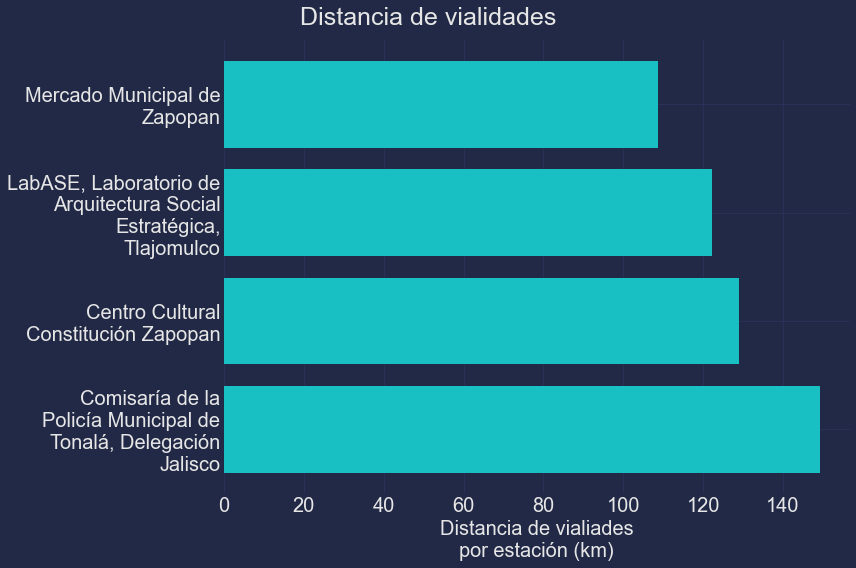

In [38]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(12,8))
#ax.barh(buffer['Nombre'].apply(lambda x: x.split(' ',maxsplit=1)[1]), buffer['sum_length']/1000)
ax.barh(buffer['GraphName'], buffer['sum_length']/1000)
ax.set_xlabel('Distancia de vialiades\npor estación (km)',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Distancia de vialidades',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_transporte/DistanciaVialidades_pipV2.png',dpi=300)

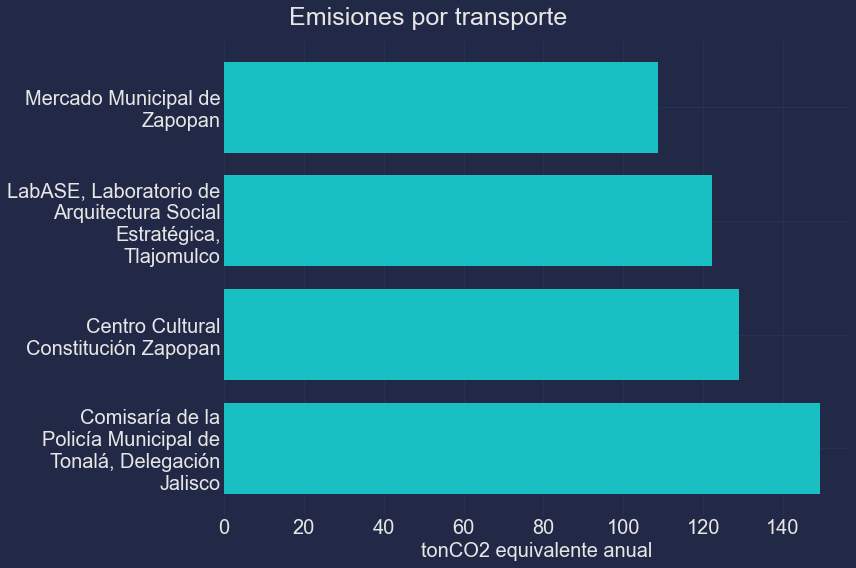

In [39]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(12,8))
#ax.barh(buffer['Nombre'].apply(lambda x: x.split(' ',maxsplit=1)[1]), buffer['tonCO₂eq'])
ax.barh(buffer['GraphName'], buffer['sum_length']/1000)
ax.set_xlabel('tonCO2 equivalente anual',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Emisiones por transporte',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_pipV2.png',dpi=300)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_pipV".svg',dpi=300)

In [16]:
dist = 1000
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'Longitud']
    y = gdf_est.at[i,'Latitud']
    est = gdf_est.at[i,'Nombre']
    point = (y, x)
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

In [17]:
edges = pd.concat(edges_data, ignore_index=True)
edges = ox.project_gdf(edges,to_crs='EPSG:32613')
edges

,osmid,highway,oneway,length,lanes,ref,name,maxspeed,geometry,access,junction,tunnel,service,u,v,key,Estacion,width,bridge
0,896862260,service,False,3.271,NaN,NaN,NaN,NaN,"LINESTRING (668260.948 2291779.265, 668259.163...",NaN,NaN,NaN,NaN,321259269,8337599020,0,Mercado Municipal de Zapopan,NaN,NaN
1,939038883,primary,True,14.493,3,MEX 23,Avenida Manuel Ávila Camacho,50,"LINESTRING (668260.948 2291779.265, 668273.038...",NaN,NaN,NaN,NaN,321259269,8336492170,0,Mercado Municipal de Zapopan,NaN,NaN
2,619650095,secondary,False,14.561,2,NaN,Calle Constitución,NaN,"LINESTRING (666555.795 2292514.061, 666545.291...",NaN,NaN,NaN,NaN,494386198,494386204,0,Mercado Municipal de Zapopan,NaN,NaN
3,619650095,secondary,False,41.514,2,NaN,Calle Constitución,NaN,"LINESTRING (666555.795 2292514.061, 666587.687...",NaN,NaN,NaN,NaN,494386198,8392628503,0,Mercado Municipal de Zapopan,NaN,NaN
4,619650095,secondary,False,14.561,2,NaN,Calle Constitución,NaN,"LINESTRING (666545.291 2292504.005, 666555.795...",NaN,NaN,NaN,NaN,494386204,494386198,0,Mercado Municipal de Zapopan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9000,693360544,tertiary,True,157.735,NaN,NaN,Avenida Camino Real,NaN,"LINESTRING (669985.802 2270508.820, 669899.278...",NaN,NaN,NaN,NaN,8776251695,1751813543,0,"LabASE, Laboratorio de Arquitectura Social Est...",NaN,NaN
9001,494336019,tertiary,True,40.491,NaN,NaN,Avenida de los Altos,NaN,"LINESTRING (668877.297 2270900.893, 668869.792...",NaN,NaN,NaN,NaN,8778633430,1755681462,0,"LabASE, Laboratorio de Arquitectura Social Est...",NaN,NaN
9002,473168858,tertiary,True,21.137,NaN,NaN,Avenida de los Altos,NaN,"LINESTRING (668853.295 2270896.071, 668856.703...",NaN,NaN,NaN,NaN,8778633435,4860866749,0,"LabASE, Laboratorio de Arquitectura Social Est...",NaN,NaN
9003,948390076,tertiary_link,True,28.234,NaN,NaN,NaN,NaN,"LINESTRING (668853.295 2270896.071, 668858.292...",NaN,NaN,NaN,NaN,8778633435,8778633430,0,"LabASE, Laboratorio de Arquitectura Social Est...",NaN,NaN


In [18]:
gdf_est_ = gpd.sjoin(gdf_est,buffer.drop(columns=['Nombre']))
gdf_est_ = gdf_est_.drop_duplicates(subset = 'Nombre', keep = 'first')
gdf_est_.head(1)

,Nombre,Latitud,Longitud,geometry,municipio_left,index_right,municipio_right,sum_length,tonCO₂eq
0,Mercado Municipal de Zapopan,20.722076,-103.391246,POINT (667520.005 2292221.880),Zapopan,0,Zapopan,108673.144349,6.085494


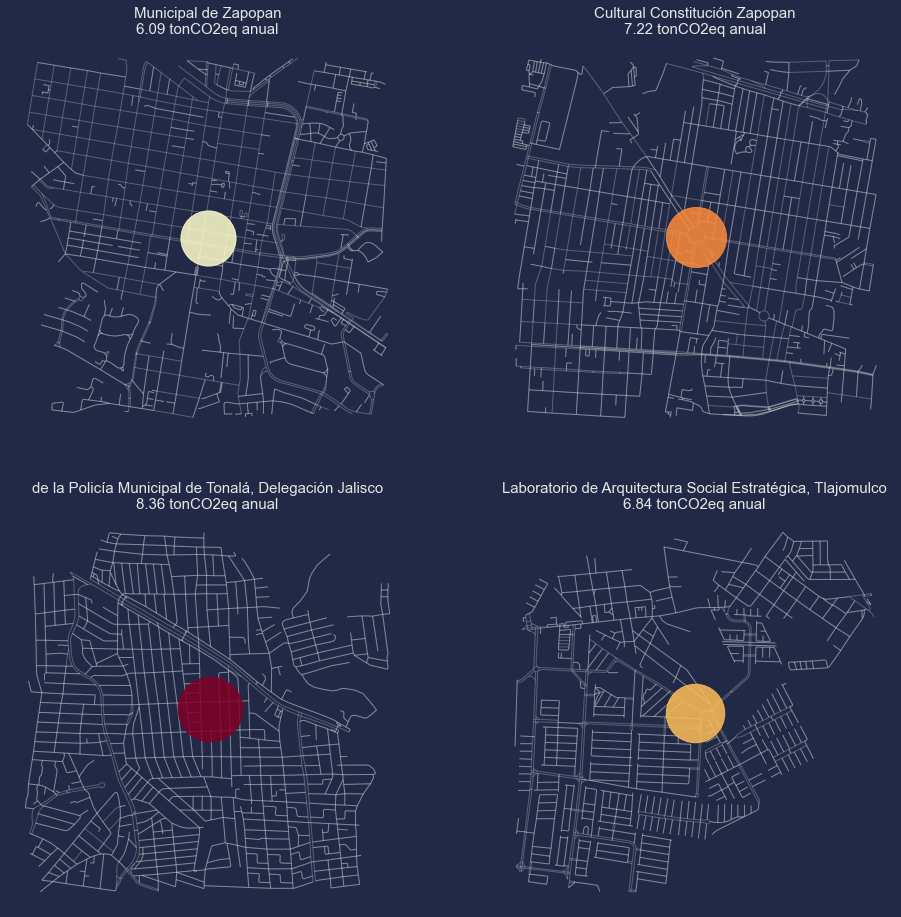

In [42]:
fig, axes = plt.subplots(2,2,figsize = (16,16))
for i, ax in zip(gdf_est_.index.tolist(), axes.flatten()):
    est = gdf_est_.at[i,'Nombre']
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    gdf_est_[gdf_est_['Nombre'] == est].plot(ax=ax, column ='tonCO₂eq', cmap='YlOrRd', markersize=gdf_est_[gdf_est_['Nombre'] == est]['tonCO₂eq']*500, alpha=0.85, zorder=3, vmin=gdf_est_['tonCO₂eq'].min(), vmax=gdf_est_['tonCO₂eq'].max())
    ax.set_title('{}\n{:,} tonCO2eq anual'.format(est.split(' ',maxsplit=1)[1], round(gdf_est_[gdf_est_['Nombre'] == est]['tonCO₂eq'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_Mapa_pipV2.png',dpi=300)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_Mapa_pipV2.svg',dpi=300)